In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [ ]:
# data_dir = '/content/drive/MyDrive/Plant Disease/'

data_dir = '/content/drive/MyDrive/Plant_Disease_Subset/'


Train Test Split

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2300 files belonging to 20 classes.
Using 1840 files for training.
Found 2300 files belonging to 20 classes.
Using 460 files for validation.


# Class Names

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Chilli_leaf_curl', 'Chilli_leaf_spot', 'Chilli_whitefly', 'Chilli_yellowish', 'Chillli_healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


(32, 180, 180, 3)
(32,)


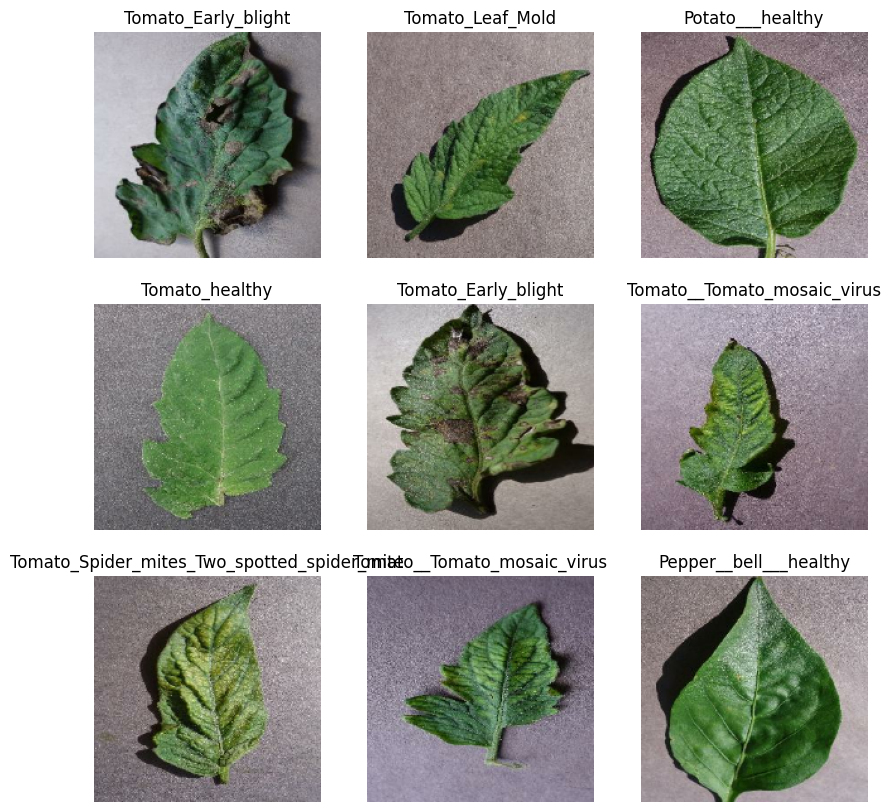

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0008888008 0.89805436


In [ ]:
#Augumentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

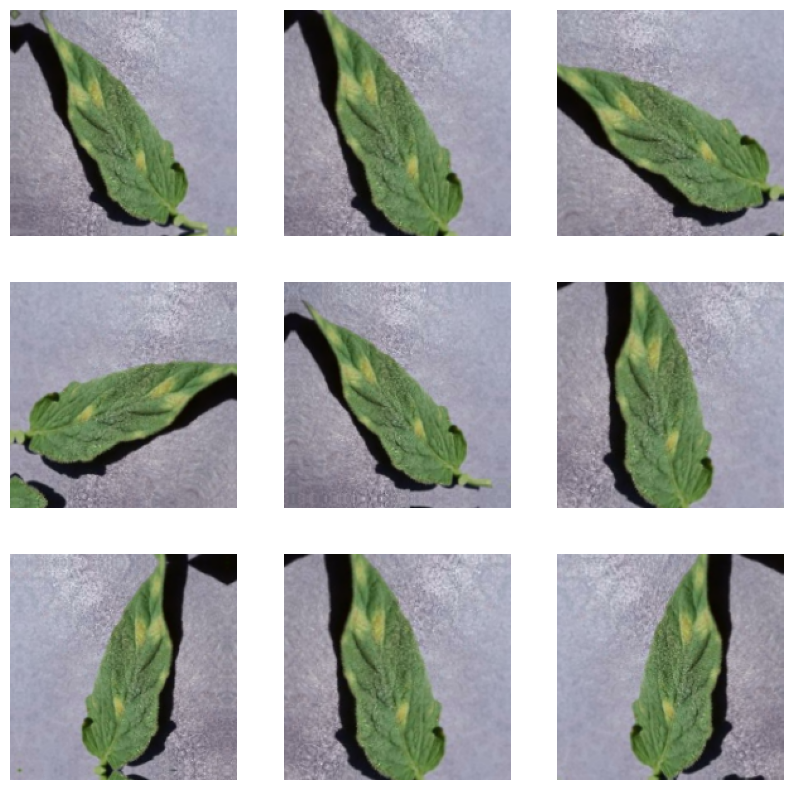

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = len(class_names)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
58/58 [==============================] - 79s 1s/step - loss: 2.8343 - accuracy: 0.1109 - val_loss: 2.4965 - val_accuracy: 0.1717
Epoch 2/10
58/58 [==============================] - 2s 31ms/step - loss: 2.2030 - accuracy: 0.2777 - val_loss: 1.9795 - val_accuracy: 0.3826
Epoch 3/10
58/58 [==============================] - 2s 31ms/step - loss: 1.8593 - accuracy: 0.3870 - val_loss: 1.7156 - val_accuracy: 0.4043
Epoch 4/10
58/58 [==============================] - 2s 30ms/step - loss: 1.6712 - accuracy: 0.4435 - val_loss: 1.5618 - val_accuracy: 0.4783
Epoch 5/10
58/58 [==============================] - 2s 29ms/step - loss: 1.4608 - accuracy: 0.5190 - val_loss: 1.3068 - val_accuracy: 0.5848
Epoch 6/10
58/58 [==============================] - 2s 30ms/step - loss: 1.2896 - accuracy: 0.5696 - val_loss: 1.3851 - val_accuracy: 0.5522
Epoch 7/10
58/58 [==============================] - 2s 30ms/step - loss: 1.2469 - accuracy: 0.5837 - val_loss: 1.1390 - val_accuracy: 0.6348
Epoch 8/10
58/

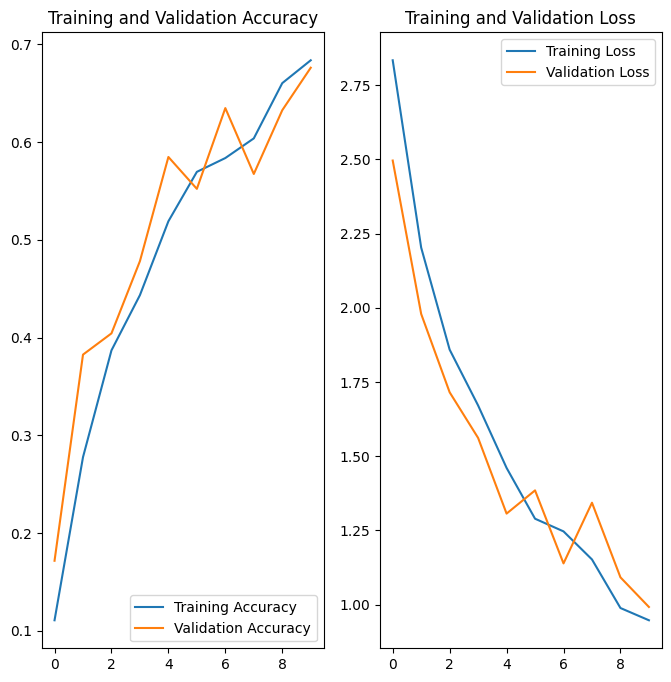

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(type(model))  # Print the type of the 'model' variable
print(dir(model))   # Print the attributes and methods of the 'model' variable


<class 'keras.src.engine.sequential.Sequential'>
['_SCALAR_UPRANKING_ON', '_TF_MODULE_IGNORED_PROPERTIES', '__annotations__', '__call__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_trackable', '_add_trackable_child', '_add_variable_with_custom_getter', '_aggregate_exact_metrics', '_assert_compile_was_called', '_assert_weights_created', '_auto_get_config', '_auto_track_sub_layers', '_autocast', '_autographed_call', '_autotune_steps_per_execution', '_base_model_initialized', '_build_graph_network_for_inferred_shape', '_build_input_shape', '_call_spec', '_callable_losses', '_captured_weight_regularizer',

In [ ]:
# Assuming 'model' is your trained model

model.save('/content/drive/MyDrive/Saved Model/trained_model.keras')
model.save('/content/drive/MyDrive/Saved Model/trained_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Provide the path to your saved model file
model_path = '/content/drive/MyDrive/Saved Model/trained_model.keras'

# Load the model
model = load_model(model_path)


In [ ]:
import os
from keras.preprocessing import image
import numpy as np
test_data_dir = '/content/drive/MyDrive/test_ds'
# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Unique classes found during iteration
unique_classes_found = set()

# Extracted pattern for class names
class_name_pattern = ['Chilli_leaf_curl', 'Chilli_leaf_spot', 'Chilli_whitefly', 'Chilli_yellowish', 'Chillli_healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
# Function to preprocess the input image
def preprocess_image(img_path):
    try:
        img = image.load_img(img_path, target_size=(180, 180))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None
# Iterate through each class (subdirectory) in the test data directory
for plant_class in os.listdir(test_data_dir):
    class_path = os.path.join(test_data_dir, plant_class)

    # Check if it is a directory
    if os.path.isdir(class_path):
        unique_classes_found.add(plant_class)

        # Iterate through each image in the class
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            # Preprocess the image
            img_array = preprocess_image(img_path)

            if img_array is not None:
                # Make predictions
                predictions = model.predict(img_array)
                predicted_class = np.argmax(predictions)

                # Extract the class name based on the pattern
                true_class_name = next((name for name in class_name_pattern if name in img_path), None)

                # Append true and predicted labels
                true_labels.append(true_class_name)
                predicted_labels.append(class_name_pattern[predicted_class])  # Use the pattern for consistency

                # Display the result
                print(f"Image: {img_path}")
                print(f"Predicted class: {class_name_pattern[predicted_class]} ({true_class_name})")
                print("------")




1/1 [==============================] - 0s 310ms/step
Image: /content/drive/MyDrive/test_ds/Potato___Early_blight/92757a8e-b68a-45b3-9d70-0281c8ea90ca___RS_Early.B 7199.JPG
Predicted class: Potato___Early_blight (Potato___Early_blight)
------
1/1 [==============================] - 0s 17ms/step
Image: /content/drive/MyDrive/test_ds/Potato___Early_blight/3a97c74a-3d6e-4cd9-86e0-10a8e716e7b5___RS_Early.B 8422.JPG
Predicted class: Tomato__Target_Spot (Potato___Early_blight)
------
1/1 [==============================] - 0s 17ms/step
Image: /content/drive/MyDrive/test_ds/Potato___Early_blight/cc48c415-4a2d-4d8d-94db-c736e7b7c882___RS_Early.B 7705.JPG
Predicted class: Potato___Early_blight (Potato___Early_blight)
------
1/1 [==============================] - 0s 25ms/step
Image: /content/drive/MyDrive/test_ds/Potato___Early_blight/df67aec2-c706-4a6f-8a4a-e11d7eb41eb8___RS_Early.B 7287.JPG
Predicted class: Potato___Early_blight (Potato___Early_blight)
------
1/1 [==============================] 

Classification Report:
                                             precision    recall  f1-score   support

                           Chilli_leaf_curl       0.67      0.20      0.31        20
                           Chilli_leaf_spot       0.69      0.55      0.61        20
                            Chilli_whitefly       0.77      0.85      0.81        20
                           Chilli_yellowish       0.80      0.60      0.69        20
                            Chillli_healthy       0.56      0.95      0.70        20
              Pepper__bell___Bacterial_spot       0.63      0.60      0.62        20
                     Pepper__bell___healthy       0.59      0.85      0.69        20
                      Potato___Early_blight       0.78      0.70      0.74        30
                       Potato___Late_blight       1.00      0.00      0.00        20
                           Potato___healthy       0.80      0.80      0.80        20
                      Tomato_Bacterial_sp

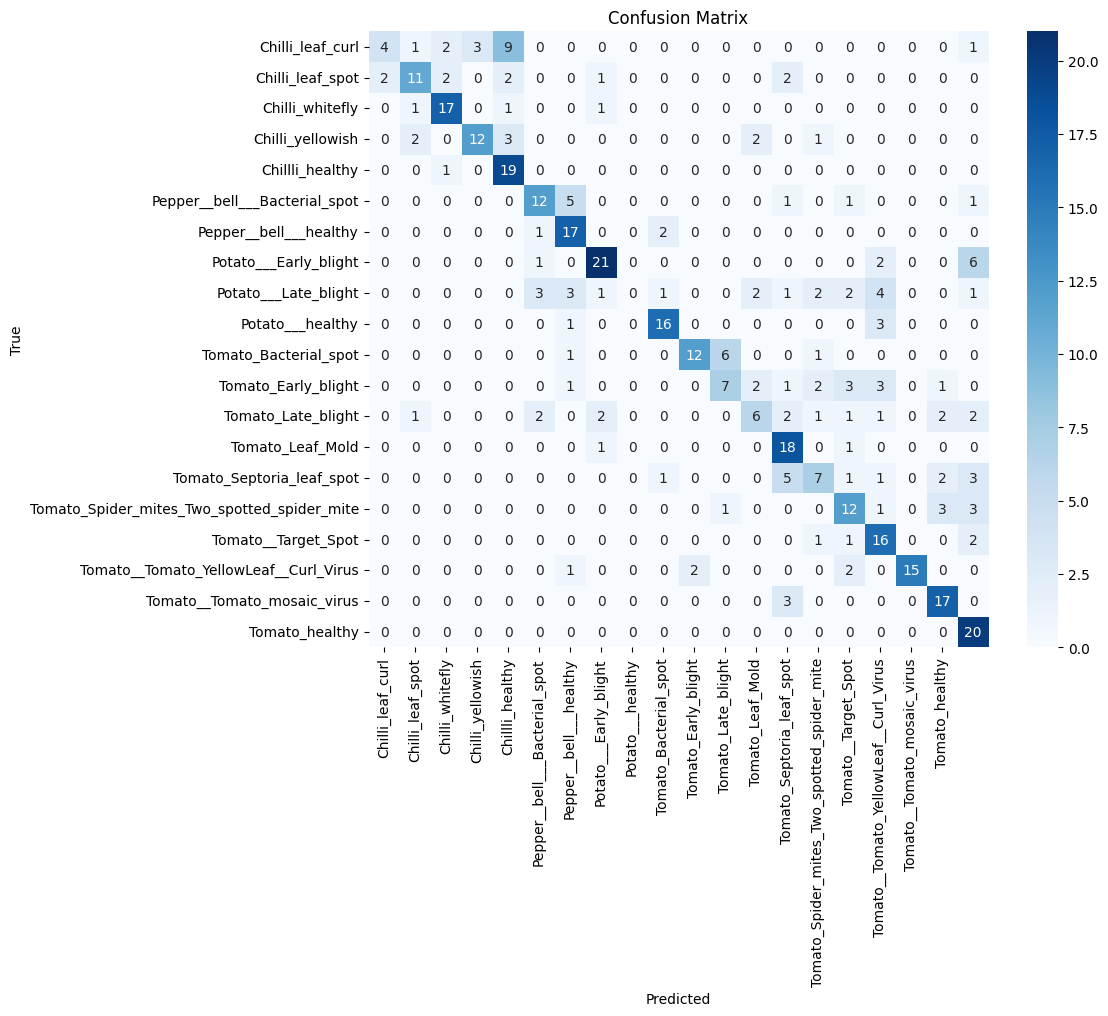

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report with zero_division parameter
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=np.unique(true_labels), zero_division=1))

# Convert labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Print unique classes found during iteration and those present in predicted labels
print("Unique classes found during iteration:", unique_classes_found)
print("Unique classes present in predicted labels:", np.unique(predicted_labels))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(predicted_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Print classification report with zero_division parameter
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=np.unique(true_labels), zero_division=1))

Classification Report:
                                             precision    recall  f1-score   support

                           Chilli_leaf_curl       0.67      0.20      0.31        20
                           Chilli_leaf_spot       0.69      0.55      0.61        20
                            Chilli_whitefly       0.77      0.85      0.81        20
                           Chilli_yellowish       0.80      0.60      0.69        20
                            Chillli_healthy       0.56      0.95      0.70        20
              Pepper__bell___Bacterial_spot       0.63      0.60      0.62        20
                     Pepper__bell___healthy       0.59      0.85      0.69        20
                      Potato___Early_blight       0.78      0.70      0.74        30
                       Potato___Late_blight       1.00      0.00      0.00        20
                           Potato___healthy       0.80      0.80      0.80        20
                      Tomato_Bacterial_sp

In [ ]:
print("Thanks! 😊")

Thanks! 😊
